In [2]:
import pandas as pd

temperatura (e imagino que todos) datos cada 5 minutos

parametros: 
- gente que entra
- temperatura
- 

## Datos de ocupación

In [3]:
import requests
import datetime
import time
import pandas as pd
import os

def obtener_datos_api(base_url, sensor_type_names=None, from_date=None, to_date=None, location_ids=None, tipo=None):
    """
    Extrae datos de una API en periodos de un mes y los guarda en un CSV consolidado.
    
    :param base_url: URL base de la API.
    :param sensor_type_names: Lista de nombres de sensores a consultar (opcional).
    :param from_date: Fecha de inicio en formato 'DD-MM-YYYY HH:MM' (opcional).
    :param to_date: Fecha de fin en formato 'DD-MM-YYYY HH:MM' (opcional).
    :param location_ids: Lista de IDs de ubicación (opcional).
    :param tipo: "aves" para conteo de aves, o cualquier otro valor para datos de series.
    :return: DataFrame consolidado con todos los datos.
    """
    
    def convertir_a_milisegundos(fecha_str):
        dt = datetime.datetime.strptime(fecha_str, "%d-%m-%Y %H:%M")
        return int(time.mktime(dt.timetuple()) * 1000)

    def convertir_a_fecha(epoch_ms):
        return datetime.datetime.fromtimestamp(epoch_ms / 1000).strftime("%d-%m-%Y %H:%M")

    if from_date is None:
        from_date = (datetime.datetime.now() - datetime.timedelta(days=30)).strftime("%d-%m-%Y %H:%M")
    if to_date is None:
        to_date = datetime.datetime.now().strftime("%d-%m-%Y %H:%M")

    from_epoch = convertir_a_milisegundos(from_date)
    to_epoch = convertir_a_milisegundos(to_date)

    datos_consolidados = {}
    registros = []
    periodo = 30 * 24 * 60 * 60 * 1000  # 1 mes en milisegundos

    while from_epoch < to_epoch:
        next_epoch = min(from_epoch + periodo, to_epoch)

        params = {
            "fromDate": from_epoch,
            "toDate": next_epoch
        }

        if sensor_type_names:
            params["sensorTypeNames"] = ",".join(sensor_type_names)
        if location_ids:
            params["locationIds"] = ",".join(map(str, location_ids))

        try:
            response = requests.get(base_url, params=params, verify=False)
            response.raise_for_status()
            data = response.json()
        except Exception as e:
            print(f"Error en la petición: {e}")
            from_epoch = next_epoch
            continue

        print(f"Procesando datos desde {convertir_a_fecha(from_epoch)} hasta {convertir_a_fecha(next_epoch)}")

        if tipo == "aves":
            fecha = convertir_a_fecha(from_epoch)
            if "count" in data and isinstance(data["count"], list):
                for ubicacion in data["count"]:
                    loc_id = ubicacion.get("location", "desconocido")
                    for especie, cantidad in ubicacion.get("count", []):
                        registros.append({
                            "timestamp": fecha,
                            "location": loc_id,
                            "species": especie,
                            "count": cantidad
                        })
            else:
                print("La respuesta no contiene la clave 'count' esperada para tipo='aves'.")

        else:
            if "series" in data:
                for variable, series_dict in data["series"].items():
                    for series_id, puntos in series_dict.items():
                        for timestamp, valor in puntos:
                            fecha = convertir_a_fecha(timestamp)
                            if fecha not in datos_consolidados:
                                datos_consolidados[fecha] = {}
                            datos_consolidados[fecha][variable] = valor
            else:
                print("La respuesta no contiene la clave 'series'.")

        from_epoch = next_epoch

    os.makedirs("data", exist_ok=True)

    if tipo == "aves":
        if not registros:
            print("No se obtuvieron datos de aves.")
            return None

        df_final = pd.DataFrame(registros)
        df_final = df_final.sort_values(["timestamp", "location", "species"])
        csv_filename = f"data/datos_aves_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_final.to_csv(csv_filename, index=False)

    else:
        if not datos_consolidados:
            print("No se obtuvieron datos.")
            return None

        df_final = pd.DataFrame.from_dict(datos_consolidados, orient="index")
        df_final.index.name = "timestamp"
        df_final = df_final.reset_index()
        df_final = df_final.sort_values("timestamp")
        csv_filename = f"data/datos_series_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_final.to_csv(csv_filename, index=False)

    print(f"Datos guardados en {csv_filename}")
    return df_final


In [4]:

url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/hup4zYsBoTGoLusGWiIj/data" 
sensores = ["count_in", "count_out"]
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = ['hup4zYsBoTGoLusGWiIj_entrada-outdoor_38.02497_-0.65828_0']

df_final = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones)
df_final

c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_series_20250331_105828.csv


,timestamp,count_in,count_out
7929,01-10-2024 00:01,0.0,0.0
7930,01-10-2024 00:06,0.0,0.0
7931,01-10-2024 00:11,0.0,0.0
7932,01-10-2024 00:16,0.0,0.0
7933,01-10-2024 00:21,0.0,0.0
...,...,...,...
22194,31-10-2024 23:47,0.0,1.0
22195,31-10-2024 23:51,0.0,1.0
22196,31-10-2024 23:52,0.0,1.0
22197,31-10-2024 23:56,0.0,1.0


Ahora convertimos datos a integer  y creamos nueva variable `people_inside`  que representa el número de personas dentro del parque en el momento

In [5]:
df_final = pd.read_csv("data/datos_ocupacion.csv")
df_final["count_in"] = df_final["count_in"].astype('Int64')
df_final["count_out"] = df_final["count_out"].astype('Int64')
df_final["people_inside"] = df_final["count_in"] - df_final["count_out"]
df_final

,timestamp,count_in,count_out,people_inside
0,01-10-2024 00:01,0,0,0
1,01-10-2024 00:06,0,0,0
2,01-10-2024 00:11,0,0,0
3,01-10-2024 00:16,0,0,0
4,01-10-2024 00:21,0,0,0
...,...,...,...,...
39691,31-10-2024 23:47,0,1,-1
39692,31-10-2024 23:51,0,1,-1
39693,31-10-2024 23:52,0,1,-1
39694,31-10-2024 23:56,0,1,-1


## Datos de clima

In [6]:

url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/5rTM-4sB-iVpGSRJcSJV/data" 
sensores = ["temperatura", "velocidadviento", "direccionviento","lluvia", "intensidadlluvia", "radiacionsolar"]
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = ['5rTM-4sB-iVpGSRJcSJV_La Mata - Parque Natural_38.02519_-0.65845_0']

df_meteo = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones)
df_meteo


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_series_20250331_105834.csv


,timestamp,temperatura,velocidadviento,lluvia,intensidadlluvia
6040,01-10-2024 00:00,20.8,0,0.0,0.0
6041,01-10-2024 00:05,20.8,0,0.0,0.0
6042,01-10-2024 00:10,20.7,0,0.0,0.0
6043,01-10-2024 00:15,20.5,0,0.0,0.0
6044,01-10-2024 00:20,20.4,0,0.0,0.0
...,...,...,...,...,...
14929,31-10-2024 23:35,18.2,0,0.0,0.0
14930,31-10-2024 23:40,18.1,0,0.0,0.0
14931,31-10-2024 23:45,18.1,0,0.0,0.0
14932,31-10-2024 23:50,17.9,0,0.0,0.0


In [7]:
df_meteo

,timestamp,temperatura,velocidadviento,lluvia,intensidadlluvia
6040,01-10-2024 00:00,20.8,0,0.0,0.0
6041,01-10-2024 00:05,20.8,0,0.0,0.0
6042,01-10-2024 00:10,20.7,0,0.0,0.0
6043,01-10-2024 00:15,20.5,0,0.0,0.0
6044,01-10-2024 00:20,20.4,0,0.0,0.0
...,...,...,...,...,...
14929,31-10-2024 23:35,18.2,0,0.0,0.0
14930,31-10-2024 23:40,18.1,0,0.0,0.0
14931,31-10-2024 23:45,18.1,0,0.0,0.0
14932,31-10-2024 23:50,17.9,0,0.0,0.0


 ## Datos de aves

In [8]:
url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/jBAFzo8B1ljoqTiFuu2B/data/count?/" 
sensores = []
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = []

df_aves = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones, "aves")
df_aves

c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01
Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01
Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_aves_20250331_105835.csv


c:\Users\JUAN LENOVO\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,timestamp,location,species,count
107,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Alectoris rufa,1
108,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Anthus pratensis,1
109,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Ardea ibis,1
110,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Carduelis carduelis,1
111,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Columba palumbus,1
...,...,...,...,...
75,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Erithacus rubecula,1
76,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Myiopsitta monachus,1
69,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Phalacrocorax carbo,2
77,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Streptopelia decaocto,1


In [9]:
df_aves

,timestamp,location,species,count
107,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Alectoris rufa,1
108,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Anthus pratensis,1
109,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Ardea ibis,1
110,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Carduelis carduelis,1
111,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Columba palumbus,1
...,...,...,...,...
75,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Erithacus rubecula,1
76,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Myiopsitta monachus,1
69,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Phalacrocorax carbo,2
77,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Streptopelia decaocto,1


# METHOD

## Data Analitics:

- Data curation
- Data description
- Data Inference


Dado que los datos de count_in son incrementales y no tenemos datos exactos de las personas que entra y salen del parque, usamos el número de personas que entran por día y haremos la predicción por días en lugar de por horas.
A continuación nos quedamos con las filas con valor máximo de count_in por cada día.

In [ ]:
ocupacion = pd.read_csv("data/datos_ocupacion.csv")
ocupacion['timestamp'] = pd.to_datetime(ocupacion['timestamp'], dayfirst=True)
ocupacion['fecha'] = ocupacion['timestamp'].dt.date
df_ocupacion_dia = ocupacion.loc[ocupacion.groupby('fecha')['count_in'].idxmax()]
df_ocupacion_dia = df_ocupacion_dia[['fecha', 'count_in']]
df_ocupacion_dia

,fecha,count_in
11060,2024-09-10,98.0
12870,2024-09-11,114.0
14261,2024-09-12,133.0
15819,2024-09-13,167.0
17349,2024-09-14,199.0
...,...,...
7106,2024-12-06,151.0
8339,2024-12-07,128.0
9539,2024-12-08,163.0
10819,2024-12-09,50.0


Siguiendo la lógica anterior y para poder hacer el análisis y estudiar la correlación entre las personas en el parque y las distintas variables debemos agregarlas por días, teniendo asíu granularidad diaria en todas ellas

-  **temperatura**:  _temp_min_, _temp_max_ y _temp_promedio_
-  **velocidadviento**:  _viento_promedio_ y _viento_max_ 
- **lluvia**: _precipitacion_acumulada_ y _duracion_lluvia_min_
- **intensidadlluvia**: _intensidad_max_ e _intensidad_promedio_

Count in segmentar en lluvia y uno lluvia. Hacer test de hipotesis y ver si hay diferencias entre ellos.  Segmentar también entre semana y fin de semana.

TEMPERATURA PROMEDIO : 3 intervalos: fria ( < 15 ) moderada (15 - 27) y alta (>27) 

In [11]:
meteo = pd.read_csv("data/datos_meteo.csv")
meteo['timestamp'] = pd.to_datetime(meteo['timestamp'], dayfirst=True)


meteo['fecha'] = meteo['timestamp'].dt.date

meteo = meteo.groupby('fecha').agg(
    temp_min=('temperatura', 'min'),
    temp_max=('temperatura', 'max'),
    temp_promedio=('temperatura', 'mean'),

    viento_max=('velocidadviento', 'max'),
    viento_promedio=('velocidadviento', 'mean'),

    precioutacion_acumulada=('lluvia', 'sum'),
    duracion_lluvia_min=('lluvia', lambda x: (x > 0).sum() * 5),  # minutos de lluvia

    # Intensidad de lluvia
    intensidad_max=('intensidadlluvia', 'max'),
    intensidad_promedio=('intensidadlluvia', 'mean')
).reset_index()

meteo = meteo.round(2)
meteo

,fecha,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88,2024-12-07,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0
91,2024-12-10,6.8,16.6,10.76,10,3.21,0.0,0,0.0,0.0


Juntamos los datos de ocupación y las variables climáticas en un mismo dataframe final

In [12]:
df = pd.merge(df_ocupacion_dia, meteo, on='fecha', how='left')

In [13]:
df

,fecha,count_in,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,98.0,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,114.0,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,133.0,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,167.0,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,199.0,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,12.9,25.9,19.13,18,5.29,0.0,0,0.0,0.0
88,2024-12-07,128.0,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,163.0,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,50.0,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0


Vamos a estudiar la correlación entre las distintas variables y el número de personas en el parque ese día.  
Utilizaremos la Correlación de Pearson y representaremos los resultados en heatmap:  
- Valores cercanos a +1: correlación positiva fuerte
- Valores cercanos a -1: correlación negativa fuerte
- Valores cercanos a 0: sin correlación

Correlaciones con count_in:
count_in                   1.000000
temp_min                   0.256609
temp_promedio              0.248542
temp_max                   0.158723
viento_promedio            0.054132
viento_max                 0.045748
intensidad_max            -0.104990
intensidad_promedio       -0.151955
precioutacion_acumulada   -0.173954
duracion_lluvia_min       -0.225924
Name: count_in, dtype: float64


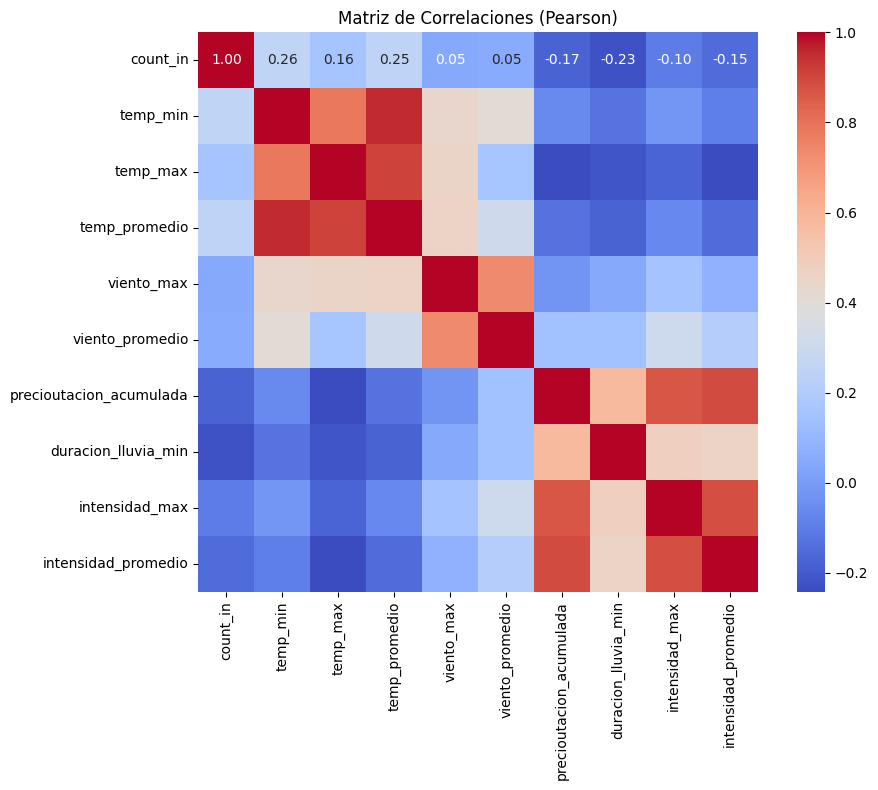

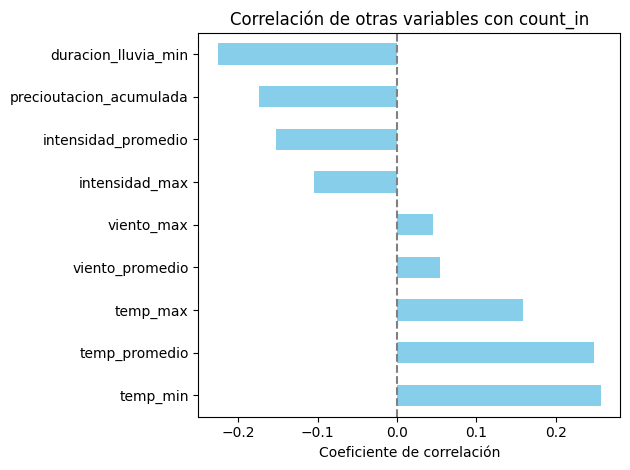

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_corr= df.select_dtypes(include='number')
correlaciones = df_corr.corr(method='pearson')

correlacion_con_count_in = correlaciones['count_in'].sort_values(ascending=False)

print("Correlaciones con count_in:")
print(correlacion_con_count_in)

plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlaciones (Pearson)')
plt.tight_layout()
plt.show()

correlacion_con_count_in.drop('count_in').plot(kind='barh', color='skyblue')
plt.title('Correlación de otras variables con count_in')
plt.xlabel('Coeficiente de correlación')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## Data Visualization

- time series using timeGPT / Prohet / ...
LOOK FOR THE BEST TECHNIQUE FOR OUR DATA

Hacer solo con count_in y con día de la semana etc

In [15]:
df_ts = df[['fecha', 'count_in']].copy()
df_ts.rename(columns={'fecha': 'ds', 'count_in': 'y'}, inplace=True)

df_ts['ds'] = pd.to_datetime(df_ts['ds'])
df_ts

,ds,y
0,2024-09-10,98.0
1,2024-09-11,114.0
2,2024-09-12,133.0
3,2024-09-13,167.0
4,2024-09-14,199.0
...,...,...
87,2024-12-06,151.0
88,2024-12-07,128.0
89,2024-12-08,163.0
90,2024-12-09,50.0


In [27]:
from nixtla import NixtlaClient
from dotenv import load_dotenv
import os

load_dotenv()

# Obtener API key
API_KEY = os.getenv("TIMEGPT_API_KEY")

# Setear clave
nixtla_client = NixtlaClient(API_KEY)

# Forecast de los próximos 14 días (por ejemplo)
forecast = nixtla_client.forecast(df=df_ts, h=14)

# Mostrar resultados
print(forecast)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


           ds     TimeGPT
0  2024-12-11   84.368240
1  2024-12-12   88.652190
2  2024-12-13   95.748730
3  2024-12-14  129.610870
4  2024-12-15  144.725520
5  2024-12-16   99.700300
6  2024-12-17   93.928070
7  2024-12-18   96.195390
8  2024-12-19   96.907510
9  2024-12-20  103.377426
10 2024-12-21  128.906590
11 2024-12-22  145.790130
12 2024-12-23  102.785550
13 2024-12-24   99.152330


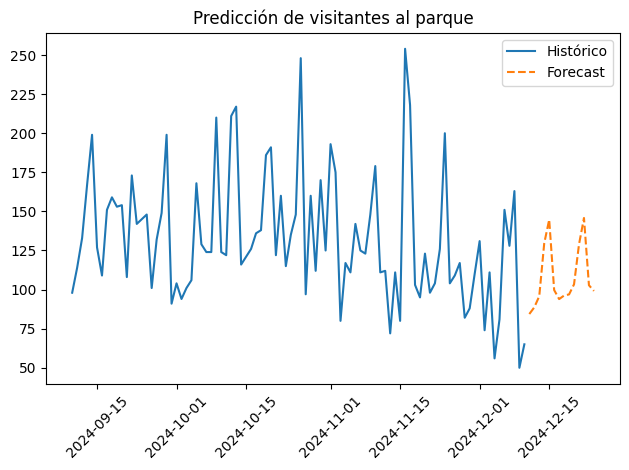

In [28]:
import matplotlib.pyplot as plt

# Graficar historial + forecast
plt.plot(df_ts['ds'], df_ts['y'], label='Histórico')
plt.plot(forecast['ds'], forecast['TimeGPT'], label='Forecast', linestyle='--')
plt.legend()
plt.title('Predicción de visitantes al parque')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Dividir datos: los primeros 77 días para entrenar, los últimos 14 como test
df_train = df_ts.iloc[:-14]   # 77 días
df_test = df_ts.iloc[-14:]    # 14 días reales

# 2. Predecir con TimeGPT
forecast = nixtla_client.forecast(df=df_train, h=14)

# 3. Alinear resultados
forecast = forecast.copy()
forecast['y_true'] = df_test['y'].values  # valores reales del test

# 4. Calcular métricas
mae = mean_absolute_error(forecast['y_true'], forecast['TimeGPT'])
rmse = np.sqrt(mean_squared_error(forecast['y_true'], forecast['TimeGPT']))

print("📊 MAE TimeGPT:", round(mae, 2))
print("📉 RMSE TimeGPT:", round(rmse, 2))


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


📊 MAE TimeGPT: 36.56
📉 RMSE TimeGPT: 42.5


- ver si es serie temporal
- ver que modelo utilizar
- como parametizar ese modelo ( cuanto datos historicos coges apra predecir )

## Variables dummys y categóricas y test de hipótesis

In [19]:


df_dummy = df.copy()
df_dummy['fecha'] = pd.to_datetime(df_dummy['fecha'])
df_dummy['lluvia'] = (df_dummy['precioutacion_acumulada'] > 0).astype(int)
df_dummy['fin_de_semana'] = df_dummy['fecha'].dt.dayofweek.isin([5, 6]).astype(int)

bins = [-float('inf'), 15, 26, float('inf')]
labels = ['fría', 'moderada', 'alta']

df_dummy['categoria_temperatura'] = pd.cut(df_dummy['temp_promedio'], bins=bins, labels=labels)
df_dummy

,fecha,count_in,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio,lluvia,fin_de_semana,categoria_temperatura
0,2024-09-10,98.0,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0,0,0,moderada
1,2024-09-11,114.0,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0,0,0,moderada
2,2024-09-12,133.0,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0,0,0,moderada
3,2024-09-13,167.0,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0,0,0,moderada
4,2024-09-14,199.0,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0,1,1,moderada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,12.9,25.9,19.13,18,5.29,0.0,0,0.0,0.0,0,0,moderada
88,2024-12-07,128.0,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0,0,1,moderada
89,2024-12-08,163.0,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0,0,1,fría
90,2024-12-09,50.0,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0,0,0,fría


## Hacemos un test de hipótisis para estudair si la lluvia afecta o no al número de visitantes

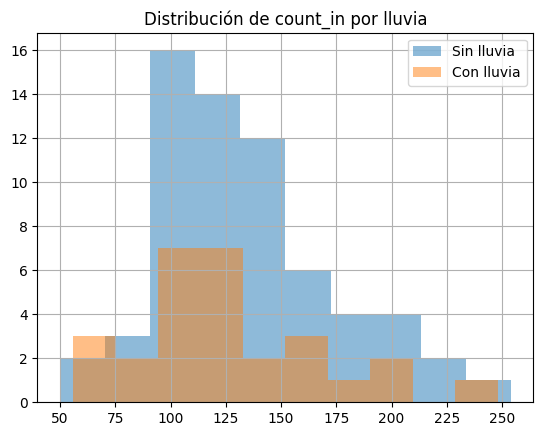

p-valor Shapiro (sin lluvia): 0.0678143422664099
p-valor Shapiro (con lluvia): 0.11722358807779393


In [20]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

df_dummy[df_dummy['lluvia'] == 0]['count_in'].hist(alpha=0.5, label='Sin lluvia')
df_dummy[df_dummy['lluvia'] == 1]['count_in'].hist(alpha=0.5, label='Con lluvia')
plt.legend()
plt.title('Distribución de count_in por lluvia')
plt.show()

shapiro_sin = shapiro(df_dummy[df_dummy['lluvia'] == 0]['count_in'])
shapiro_con = shapiro(df_dummy[df_dummy['lluvia'] == 1]['count_in'])

print("p-valor Shapiro (sin lluvia):", shapiro_sin.pvalue)
print("p-valor Shapiro (con lluvia):", shapiro_con.pvalue)


Normalidad en los datos, usamos test t

Hipótesis nula (H₀): La media de visitantes es la misma en días con y sin lluvia.  
Hipótesis alternativa (H₁): La media de visitantes es diferente entre días con y sin lluvia

In [21]:
from scipy.stats import ttest_ind, mannwhitneyu


hipo_lluvia = df_dummy[['count_in', 'lluvia']]

sin_lluvia = hipo_lluvia[hipo_lluvia['lluvia'] == 0]['count_in']
con_lluvia = hipo_lluvia[hipo_lluvia['lluvia'] == 1]['count_in']

t_stat, p_val_ttest = ttest_ind(sin_lluvia, con_lluvia, equal_var=False)


print("Test t: p-value =", p_val_ttest)


Test t: p-value = 0.3647634304049451


Resultado p-valor mayor que 0.05, lo que significa que no se rechaza la hipótesis nula.
> **Conclusión:** No hay evidencia estadísticamente significativa para afirmar que la lluvia afecte el número de visitantes al parque.


## Hacemos un test de hipótisis para estudair si que sea fin de semana o no afecta al número de visitantes

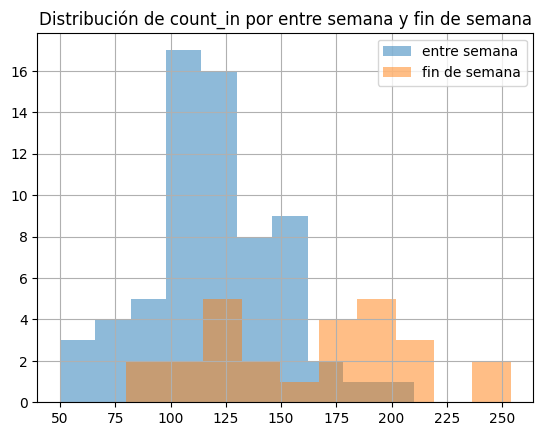

p-valor Shapiro (entre semana): 0.6183420703285243
p-valor Shapiro (fin de semana): 0.8032274130434762


In [22]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'].hist(alpha=0.5, label='entre semana')
df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'].hist(alpha=0.5, label='fin de semana')
plt.legend()
plt.title('Distribución de count_in por entre semana y fin de semana')
plt.show()

shapiro_entre = shapiro(df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'])
shapiro_fin = shapiro(df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'])

print("p-valor Shapiro (entre semana):", shapiro_entre.pvalue)
print("p-valor Shapiro (fin de semana):", shapiro_fin.pvalue)


p-valores son mayores que 0.05, no se rechaza la normalidad, así que usamos el t-test.

H₀ (nula): El número de visitantes es igual en fines de semana y días de semana.

H₁ (alternativa): El número de visitantes es diferente entre fines de semana y días de semana.

In [23]:
from scipy.stats import ttest_ind

entre_semana = df_dummy[df_dummy['fin_de_semana'] == 0]['count_in']
fin_de_semana = df_dummy[df_dummy['fin_de_semana'] == 1]['count_in']

# Test t
t_stat, p_val_t = ttest_ind(entre_semana, fin_de_semana, equal_var=False)

print("Test t: p-value =", p_val_t)


Test t: p-value = 3.7540731446008386e-05


Se realizó un test de hipótesis para evaluar si el hecho de que sea fin de semana influye en el número de visitantes al parque.

Tras comprobar que los datos de ambos grupos (entre semana y fin de semana) seguían una distribución normal mediante la prueba de Shapiro-Wilk (p > 0.05 en ambos casos), se aplicó un t-test de dos muestras independientes.

El resultado del test fue un p-valor = 0.0000375, lo cual es significativamente menor que el umbral habitual de 0.05.

Conclusión: Se rechaza la hipótesis nula. Existe evidencia estadísticamente significativa de que el número de visitantes es diferente entre fines de semana y días de semana. Es decir, ser fin de semana sí afecta al número de visitantes.

Ahora queremos saber si hay más mpersonas entre semana o fin de semana, Para ello sacamos la media de ambos grupos.

In [24]:
media_semana = df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'].mean()

media_findesemana = df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'].mean()

print("Media entre semana:", media_semana)
print("Media fin de semana:", media_findesemana)

Media entre semana: 119.66666666666667
Media fin de semana: 165.92307692307693


## Modelo de predicción

In [25]:
df_regression = df_dummy[['fecha', 'count_in', 'lluvia', 'fin_de_semana', 'categoria_temperatura']].copy() #icluimos lluvia yq ue pese a que no es significaqtiva en regresión puede serlo en predicción
df_regression

,fecha,count_in,lluvia,fin_de_semana,categoria_temperatura
0,2024-09-10,98.0,0,0,moderada
1,2024-09-11,114.0,0,0,moderada
2,2024-09-12,133.0,0,0,moderada
3,2024-09-13,167.0,0,0,moderada
4,2024-09-14,199.0,1,1,moderada
...,...,...,...,...,...
87,2024-12-06,151.0,0,0,moderada
88,2024-12-07,128.0,0,1,moderada
89,2024-12-08,163.0,0,1,fría
90,2024-12-09,50.0,0,0,fría


In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np


df = df_regression.copy()

df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_semana'] = df['fecha'].dt.dayofweek   # 0=Lunes, 6=Domingo
df['mes'] = df['fecha'].dt.month

df['festivo'] = df['dia_semana'].apply(lambda x: 1 if x == 6 else 0)

X = df.drop(columns=['count_in', 'fecha'])
y = df['count_in']

preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['categoria_temperatura'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('prepro', preprocesador),
    ('modelo', RandomForestRegressor(random_state=42)) 
])

param_dist = {
    'modelo__n_estimators': [50, 100, 200, 300],
    'modelo__max_depth': [10, 20, 30, None],
    'modelo__min_samples_split': [2, 5, 10, 15, 20],
    'modelo__min_samples_leaf': [1, 2, 4, 6]
}

search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                            n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)
search.fit(X, y)

print("✅ Mejor combinación de hiperparámetros:", search.best_params_)

best_pipeline = search.best_estimator_
scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE promedio (CV 5):", -scores.mean())

y_pred_cv = cross_val_predict(best_pipeline, X, y, cv=5)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
print("RMSE (CV 5):", rmse)

best_pipeline.fit(X, y)

nueva_fecha = pd.DataFrame({
    'lluvia': [1],
    'fin_de_semana': [0],
    'categoria_temperatura': ['moderada'],
    'dia_semana': [1],  # martes
    'mes': [9],
    'festivo': [0]
})
prediccion = best_pipeline.predict(nueva_fecha)
print("Predicción de visitantes:", prediccion[0])
prediccion

✅ Mejor combinación de hiperparámetros: {'modelo__n_estimators': 200, 'modelo__min_samples_split': 10, 'modelo__min_samples_leaf': 2, 'modelo__max_depth': 20}
MAE promedio (CV 5): 28.197133591040263
RMSE (CV 5): 35.59564348206364
Predicción de visitantes: 128.69303205046586


array([128.69303205])

### Visualizaciones

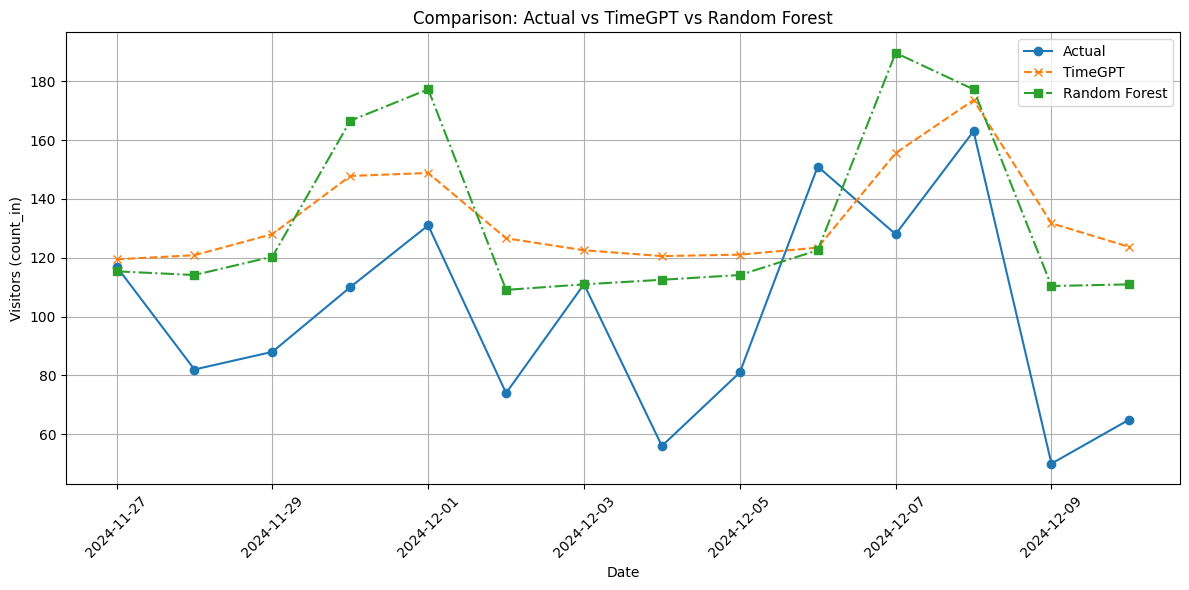

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear dataframe de comparación
df_comparacion = pd.DataFrame({
    'Fecha': df_test['ds'].values,
    'Real': df_test['y'].values,
    'TimeGPT': forecast['TimeGPT'].values,
    'RandomForest': y_pred_cv[-14:]  # ← CAMBIO AQUÍ
})

# Calcular error absoluto
df_comparacion['Error_TimeGPT'] = abs(df_comparacion['Real'] - df_comparacion['TimeGPT'])
df_comparacion['Error_RF'] = abs(df_comparacion['Real'] - df_comparacion['RandomForest'])


df_comparacion.set_index('Fecha', inplace=True)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_comparacion.index, df_comparacion['Real'], label='Actual', marker='o')
plt.plot(df_comparacion.index, df_comparacion['TimeGPT'], label='TimeGPT', linestyle='--', marker='x')
plt.plot(df_comparacion.index, df_comparacion['RandomForest'], label='Random Forest', linestyle='-.', marker='s')

plt.title('Comparison: Actual vs TimeGPT vs Random Forest')
plt.xlabel('Date')
plt.ylabel('Visitors (count_in)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


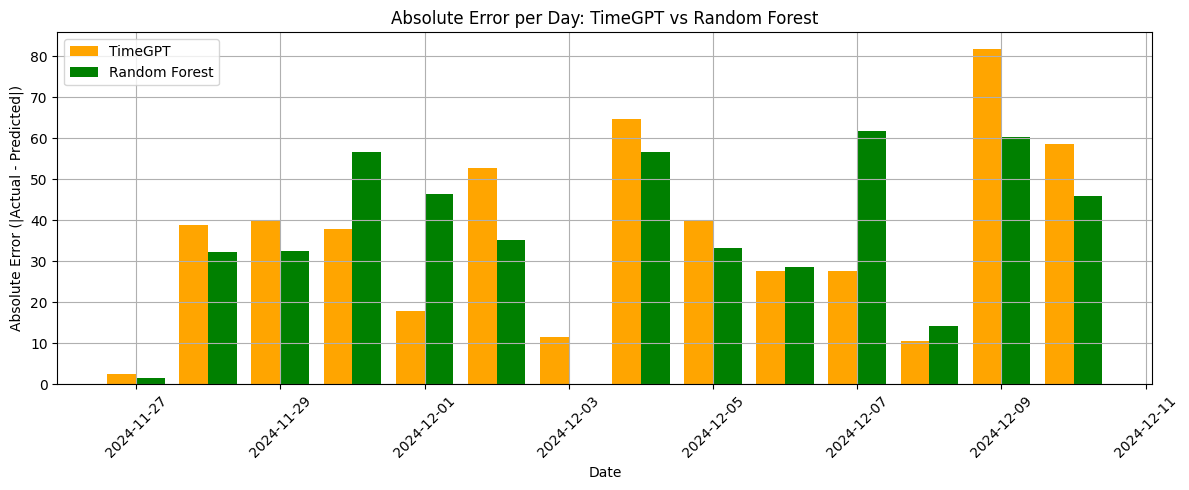

In [39]:
# Calcular errores absolutos
df_comparacion['Error_TimeGPT'] = abs(df_comparacion['Real'] - df_comparacion['TimeGPT'])
df_comparacion['Error_RF'] = abs(df_comparacion['Real'] - df_comparacion['RandomForest'])

# Graficar
plt.figure(figsize=(12, 5))
plt.bar(df_comparacion.index - pd.Timedelta(days=0.2), df_comparacion['Error_TimeGPT'], width=0.4, label='TimeGPT', color='orange')
plt.bar(df_comparacion.index + pd.Timedelta(days=0.2), df_comparacion['Error_RF'], width=0.4, label='Random Forest', color='green')

plt.title('Absolute Error per Day: TimeGPT vs Random Forest')
plt.ylabel('Absolute Error (|Actual - Predicted|)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


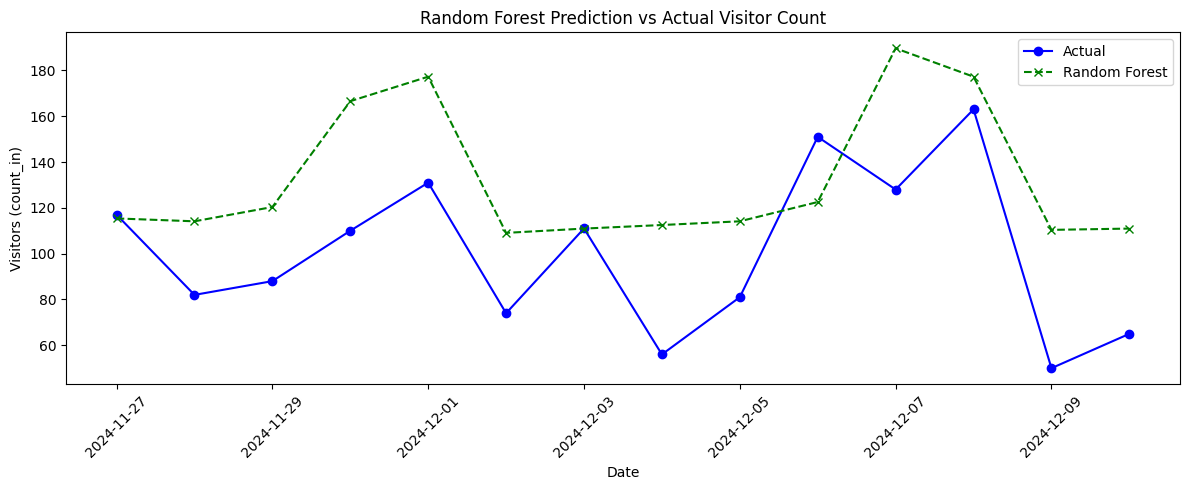

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_comparacion.index, df_comparacion['Real'], label='Actual', color='blue', marker='o')
plt.plot(df_comparacion.index, df_comparacion['RandomForest'], label='Random Forest', color='green', linestyle='--', marker='x')
plt.title('Random Forest Prediction vs Actual Visitor Count')
plt.xlabel('Date')
plt.ylabel('Visitors (count_in)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

